In [488]:
import csv, copy, gzip, pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2, multivariate_normal

%matplotlib inline

We'll use Gaussian mixture model to solve clustering problem on a simple dataset. This demo needs an external file 'gmmlib.py' to run, however, we'll not provide that file this time. It's your task to implement corresponding functions by yourself. You can modify the code in the notebook to follow your own idea or just create a file named 'gmmlib.py' under the same folder of this notebook containing function **expectation** and **maximization**.

### Load data from File

The first step is load data from given text file. This demo assuming it located under folder 'data' under same folder of this notebook. Data in the file is saved in the format of table with space as the delimiter. Each line in the file corresponds to a coordinates in 2D space. One thing to be noticed that you need to convert it into *ndarray* for convenience of following processing.

In [489]:
with open('data/faithful.txt', 'rt') as csvfile:
    dataReader = csv.reader(csvfile, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

### Gaussian Mixture Model Initialization

Now, we need to initialize a Gaussian mixture model before optimization process. At very beginning, we should pick a number of how many Gaussian distribution you want in your mixture model. Here we use two, you can test other values.

In [490]:
ngmm = 2 # quantity of Gaussian Mixture Model

Then, we should initialize mean and covariance matrix for each Gaussian distribution. Here, we assign them directly. In second part (MNIST dataset exploration), we'll use randomly initialization. **One thing to be notice is that covariance matrices have to be symmetric and positive-definite**.

You can modify numbers in this part to try different initialization settings. Combined with next part, illustration part, you can visually see your initial model. **If you modified quantity of Gaussian distribution in model in above cell, please ensure you have correspondingly add or remove entrice in *mu* and *sigma***.

In [491]:
mu = np.asarray([[2, 70], 
                 [4, 80]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]]]
                  ).astype('float')

For correctness, I create a simple function to help you check whether or not your covariance matrices are legal. So, after you modified number in cell above, run following cell to check.

In [492]:
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))

Convariance Matrices are Legal? : True


Now, we have all the elements that needed for Gaussian distributions. After initialize prior for each Gaussian distribution evenly, we can compose an array of dictionary to contain all information for the Gaussian mixture model.

In [493]:
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

### Illustration of Gaussian Mixture Model

Before we actually do optimization on Gaussian mixture model, we need a way to illustrate current state of our model. A straight forward choise is plotting. Here we implement a function, whcih can plot data points with ellipses correponding to Gaussian distribution in your mixture model. However, the implementation involves some topic out of our scope, we'll not explain it here. But, if you want to know more details about it, ther is a blog : '[How to draw a covariance error ellipse?](http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/)' can help you.

In [494]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

Now, we can use function **gmmplot** to show current state of your mixture model.

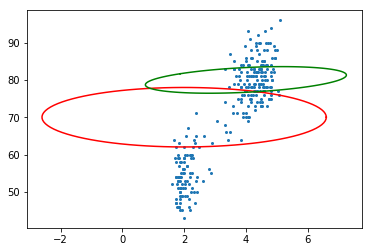

In [495]:
gmmplot(data, gmm)

### Optimize Mixture Model using EM Algorithm

We'll show a extremely simplified optmization process in this part. And it need two function **expectation** and **maximization** to run. In context of this demo, they should be contained by a file named 'gmmlib.py' under same folder of this notebook. However, we'll not provide it for you this time. You need to implement these two function by yourself.

There is no restriction for your implementation, this section is just a framework helps some student you don't have a clear idea about how to start. You can follow this framework and implement those two function in an external file. Or, you can rewrite this section in any way you like.

### E Function

The expectation function is derived similarly to the textbook, where we calculate the posterior distribution with the current data and then send that to be used in the calculation of the maximization.

For the expectation function, we will need to calculate and evaluate the posterior at the current step, to determine the probabilities of each "class". This is essentially $ p_{n,k} = p(c_k| x^{(n)}, \theta_{1:K}) $ where K is the number of classes in the mixture, $\\theta$ is the parameters for all of the classes, and $x$ refers to the nth data point.

$$ p_{k} = \sum_{n} p_{n,k} $$
To calculate $ p_{n,k} $ we need to know $ p(c_k| x^{(n)}, \theta_{1:K}) $
From Bayes rule, we get the following.
$$ p(c_k| x^{(n)}, \theta_{1:K}) = \frac{p(c_k, x^{(n)}, \theta_{1:K})}{p(x^{(n)}, \theta_{1:K})} $$
$$ p(c_k| x^{(n)}, \theta_{1:K}) = \frac{p(c_k) p(x^{(n)}, \theta_{1:K}|c_k)}{\sum_{k} p(c_k) p(x^{(n)}, \theta_{1:K}|c_k)} $$
We use the normal distribution to calculate the probability $ p(c_k) p(x^{(n)}, \theta_{1:K}|c_k)$ and then calculate the final probability. Some equations obtained from the lecture slides and textbook.

In [496]:
# E function
def expectation(data, gmm):
    ngmm = len(gmm)
    data = np.array(data)
    posteriors = np.zeros((np.size(data,0), ngmm))
    
    for model, k in zip(gmm, range(ngmm)):
        prior = model['prior']
        pdfs = multivariate_normal.pdf(data, model['mean'], model['covariance'])
        posteriors[:,k] = pdfs * prior
    
    posteriors = posteriors/np.sum(posteriors,1)[:,None]
    return posteriors

### M Function

The maximization function then takes the posterior distribution, the current $\theta$ estimation, and of course the data. Using these, it computes the next step, by maximizing the gradient by seeting the log normal distribution to zero and then evaluating it. 

We calculate the new mean by evaluating and assigning each data point to its respective model, according to the probabilities. We then take that distribution's mean and store that as the mean for each individual mixture based off of the classifications. 

Thus the equation for updating the mean is then literally $ \mu_{k} = \frac{1}{n}\Sigma_{i}^{n}x_{i} $ where $x_{i}$ is in the distribution of model k.  

In [497]:
# M function for just mean
def maximization_mean(posterior, data, gmm):
    model1 = [[],[]]
    model2 = [[],[]]
    for i in range (len(posterior)):
        if posterior[i,0] > (1 - posterior[i,0]):
            model1[0].append(data[i][0])
            model1[1].append(data[i][1])
        else:
            model2[0].append(data[i][0])
            model2[1].append(data[i][1])
    gmm[0]['mean'] = np.asarray([np.mean(model1[0]), np.mean(model1[1])])
    gmm[1]['mean'] = np.asarray([np.mean(model2[0]), np.mean(model2[1])])
    return gmm

The basic idea of optimization process here is iteratively run **expectation** and **maximization**, and stop when the stop criteria is achived. Here, we use predefined number of iterations, **but we recommend you extend it into more comprehensive ones**. Also remember to show the progress of optimization with help of **gmmplot**.

For simple case, we use function **maximization_mean**, which only change mean of distributions.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

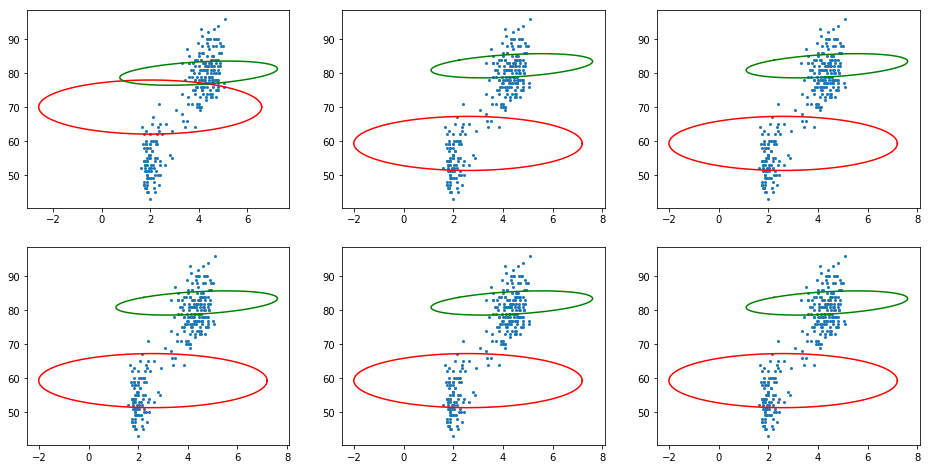

In [498]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        print(i * 5 + j, end=" ")
        posterior = expectation(data, gmmcp)
        #if i == 0 and j == 0:
            #print(posterior)
        gmmcp = maximization_mean(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

In [551]:
# Maximization function for mean, cov, and posterior/priors
def maximization(posterior, data, gmm):
    #Prior
    n = np.size(data,0)
    newPriors = np.sum(posterior,0)/n    
    for k in range(ngmm):
        gmm[k]['prior'] = newPriors[k]
        gmm[k]['mean'] = np.sum(data * posterior[:,k][:,None],0)/(n * gmm[k]['prior'])
        newCov = np.zeros((2,2))
        for x, i in zip(data, range(n)): 
            newCov += posterior[i,k] * (x - gmm[k]['mean']) * (x - gmm[k]['mean'])[:,None] 
        gmm[k]['covariance'] = newCov/(n * gmm[k]['prior'])
    return gmm   

Then, we can extend the maximization process with capability of changing covariance and prior of each Gaussain distribution at the same time.

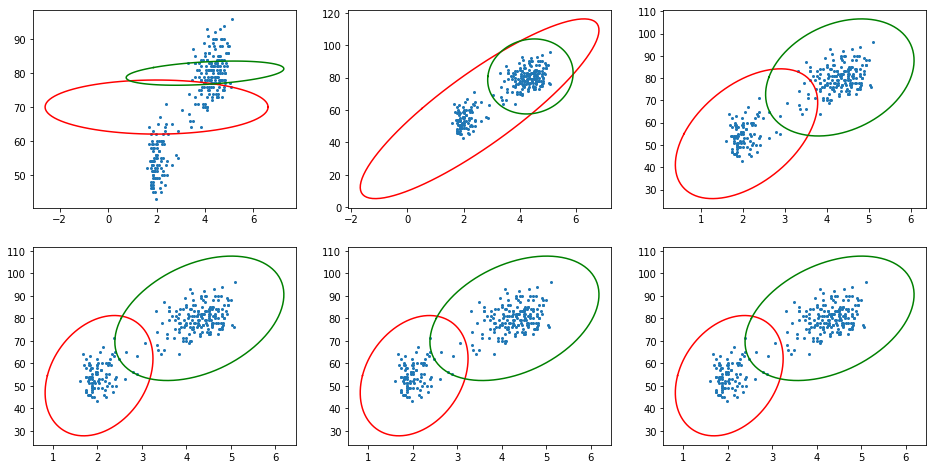

In [500]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

**Now you can play around with this model with different number of Gaussian distributions. But remember to modify your initialization correspondingly.**

## MNIST dataset exploration

After you getting familiar with Gaussian mixture model, we can apply it to a little bit complexer dataset. This time, our target is [MNIST dataset](http://yann.lecun.com/exdb/mnist/). However, each sample of it is a $28 \times 28$ binary image, which corresponds to a 724 dimensional vector. Therefore, we cannot expect our model can deal with it in short time. Here, we'll use PCA to reduce the dimensionality of it before we actually learn a Gaussian mixture model on it.

The very first step is load data from file. We have done this for you. You just need to put the file 'mnist.pkl.gz' provided with this notebook under a folder named 'data'. You also can put it to anywhere you want, but you have to modify corrresponding part in following code.

In [518]:
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    f = pickle._Unpickler(f)
    f.encoding = 'latin1'
    trainSet, validSet, testSet = f.load()
    mnistData = np.concatenate((trainSet[0], validSet[0], testSet[0]), axis=0)

For illustration purpose, we create a function for you to randomly pick specified number of image from a image dataset to show in grid arrangement.

In [519]:
def showImageSamples(imageset, n, shape=[28,28], col=3, width=16, dispopt='gray', random=True):
    row    = np.ceil(n / col)
    height = np.around(row * (width / col))
    plt.figure(figsize=(width, height))
    for i in range(n):
        if random:
            img = imageset[np.random.randint(len(imageset), size=1)]
        else:
            img = imageset[i]
        plt.subplot(row, col, i+1)
        plt.imshow(img.reshape(shape), cmap=dispopt)

Now, let's call this function to show 9 samples from MNIST dataset.

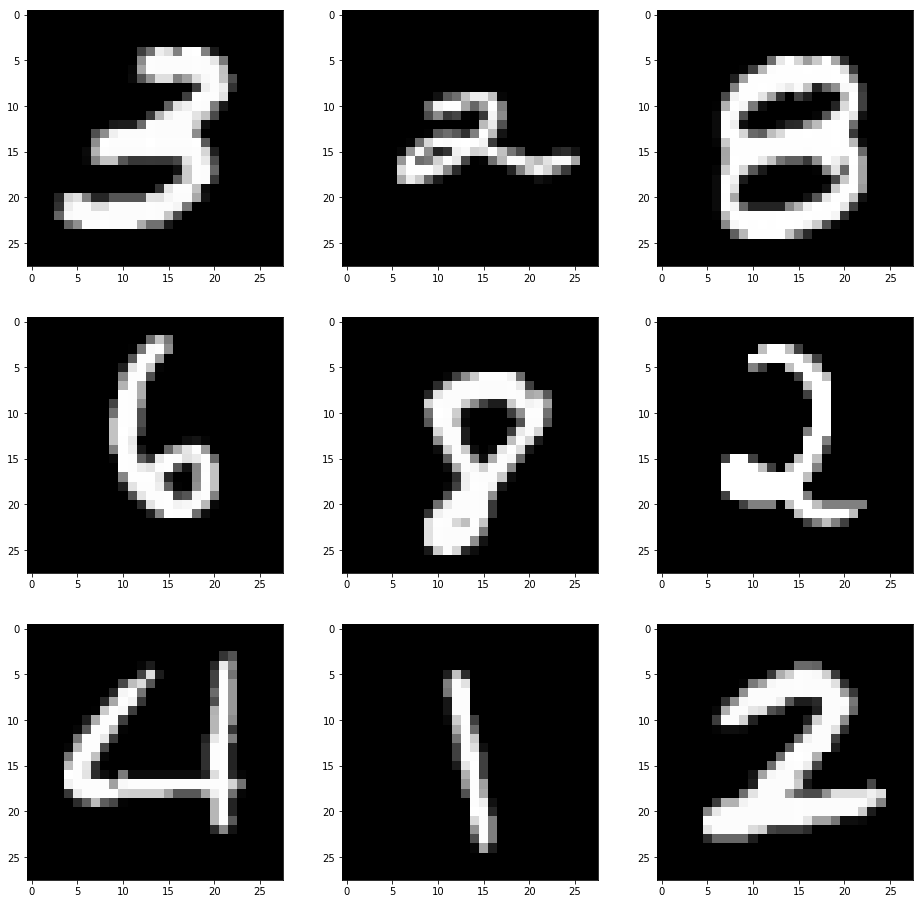

In [520]:
showImageSamples(mnistData, 9)

Next step is using PCA to reduce dimensionality of MNIST dataset. **It's your task to implement this function this time**. Here, we'll call a function in external file, which we'll not provide.

In [525]:
# dimReducePCA
from sklearn.decomposition import PCA
from sklearn import decomposition
from scipy.linalg import eig

def dimReducePCA(data, ndim=2):
    pca = PCA(n_components=ndim).fit(data)
    eigenValues, eigenVectors = eig(pca.get_covariance())
    return pca.transform(data), ((data * eigenValues).T * 100).astype("int"), eigenVectors

In [526]:
ndim = 2

# reduce the dimension of data to specific dimension using PCA
mnistDataND, eigenVectors, eigenValues = dimReducePCA(mnistData, ndim)

c:\users\rahul\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


Now, we can show first few eigen vector of MNIST dataset after PCA. 

**Notice:** 
1. Eigen vectors are arranged as column vectors in matrix, while images in dataset should be row vectors.
2. Plotting function would rescale input data into range of $[0,1]$, however, eigen vectors (PCA bases) may contain negative values. So, the plots showing below only represent relative values.

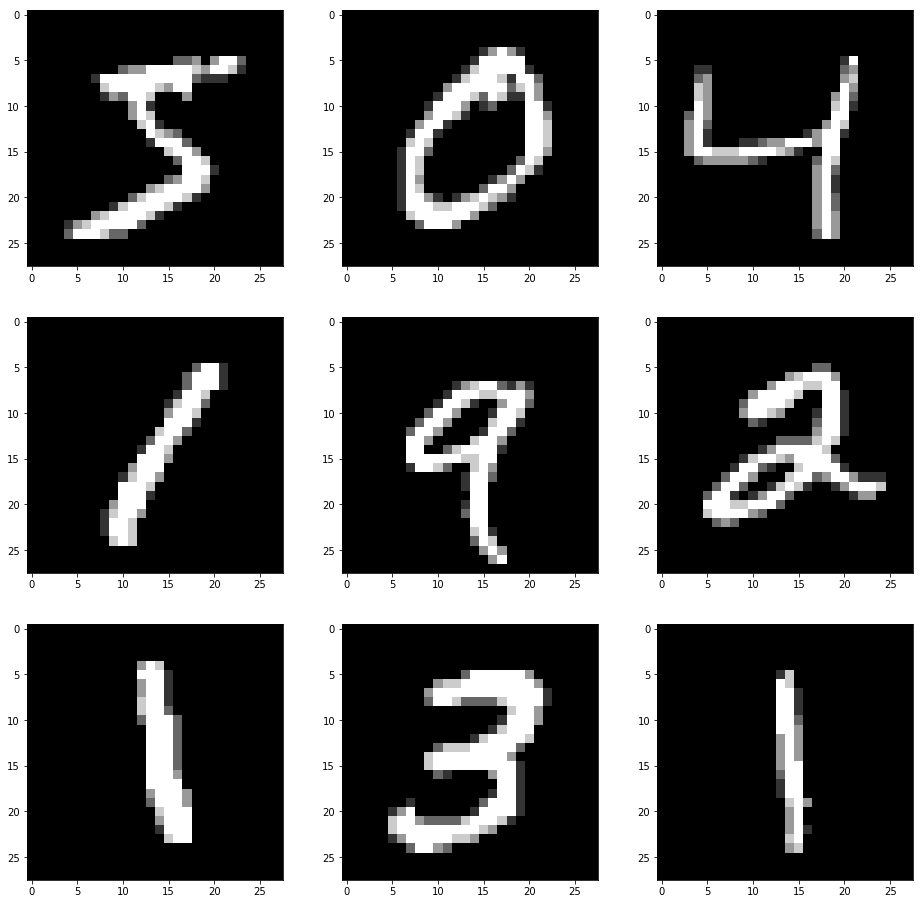

In [527]:
showImageSamples(eigenVectors.T, 9, random=False)

### Gaussian Mixture Model Randomly Initialization

Instead of assigning mean and covariance matrices by hand, this time let's initialize Gaussian mixture model randomly. There is another common way to initialize the model automatically, which assigns mean and covariance matrices according to statistics of given data. This method can help your model to start from a good spot in optimization. If you are interested in this method, you should search online and try to implement it by yourself. 

In the methods of randomly initialization, there are there parts:
1. generate mean (or center) of Gaussian distribution
2. generate covariance matrix of Gausssian distribution
3. pick priors for your Gaussian distributions

Generating mean of Gaussian distribution is quite straight foward. You can pick a random number. More reasonably, pick a number in range of your data. Here, we calculate range of data point on each dimension and pick random coordinates in it.

In [528]:
# randomly pick coordinates as center of Gaussian distribution
def randinitMean(n, drange):
    mu = []
    for m in range(n):
        mu.append([np.random.uniform(drange[i]['MIN'], drange[i]['MAX']) for i in range(len(drange))])
    # return inf form of numpy.ndarray
    return np.asarray(mu)

To generate a legal covariance matrix, we can start from its relationship with multiple dimension Gaussian distribution (currently, we use 2D version here). Because eigen vectors of covariance matrix represents axis of corresponding Gaussian distribution. Therefore, we can generate eigen vectors and eigen values at first, and then compose them into covariance matrix. **Notice: this implement only support initialization of 2D Gaussian model. You need to extend it to support other dimensionalities.** (Tips: you need to generate $n \times n$ orthogonal matrix for $n$D Gaussian model as your eigen vectors)

In [529]:
def randOrthogonalMatrix(ndim):
    ortmat = np.random.normal(size=[ndim,ndim])
    for i in range(ndim):
        # remove components exist in vector before
        r = ortmat[:,i]
        if i > 0:
            b = ortmat[:,range(i)]
            r = r - b.dot(b.T.dot(r))
        # normalize current column
        ortmat[:,i] = r / np.sqrt(r.T.dot(r))
    return ortmat

def randinitCovarianceND(n, ndim=2):
    sigma = []
    for m in range(n):
        # create eigen vectors as an orthogonal matrix
        eigenVector = randOrthogonalMatrix(ndim)
        # randomly positive values as eigen value
        eigenValue = abs(np.random.normal(size=ndim))
        # compose covariance matrix
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    return np.asarray(sigma)

### Learn GMM on reduced MNIST dataset

With help of all functions define above, we can learn a Gaussian mixture model on MNIST dataset. **However, for efficiency, we recommend you use a subset of imageset for testing purpose.** Because, optimization on whole dataset would be time consuming.

In [533]:
ndata = 2000
# randomly pick a subset of data
data = mnistDataND[np.random.randint(len(mnistDataND), size=ndata)]

First, let's initialize a Gaussian mixture model randomly and illustrate the inital state.

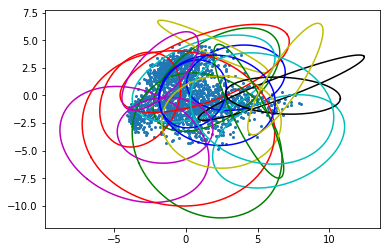

In [534]:
ngmm = 20

# get information of range on each dimension
dataRange = []
for i in range(data.shape[1]):
    dataRange.append({'MIN': min(data[:,i]), 'MAX': max(data[:,i])})
    
# randomly initialize Gaussian mixture model
mu    = randinitMean(ngmm, dataRange)
sigma = randinitCovarianceND(ngmm, ndim)
gmm   = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

# show initial state
if ndim == 2:
    gmmplot(data, gmm)

Then, optimize our model using EM Algorithm. **To be noticed, you may encounter some numerical errors when your covariance matrices degenerate. In that case, add small identity matrix to it may help.**

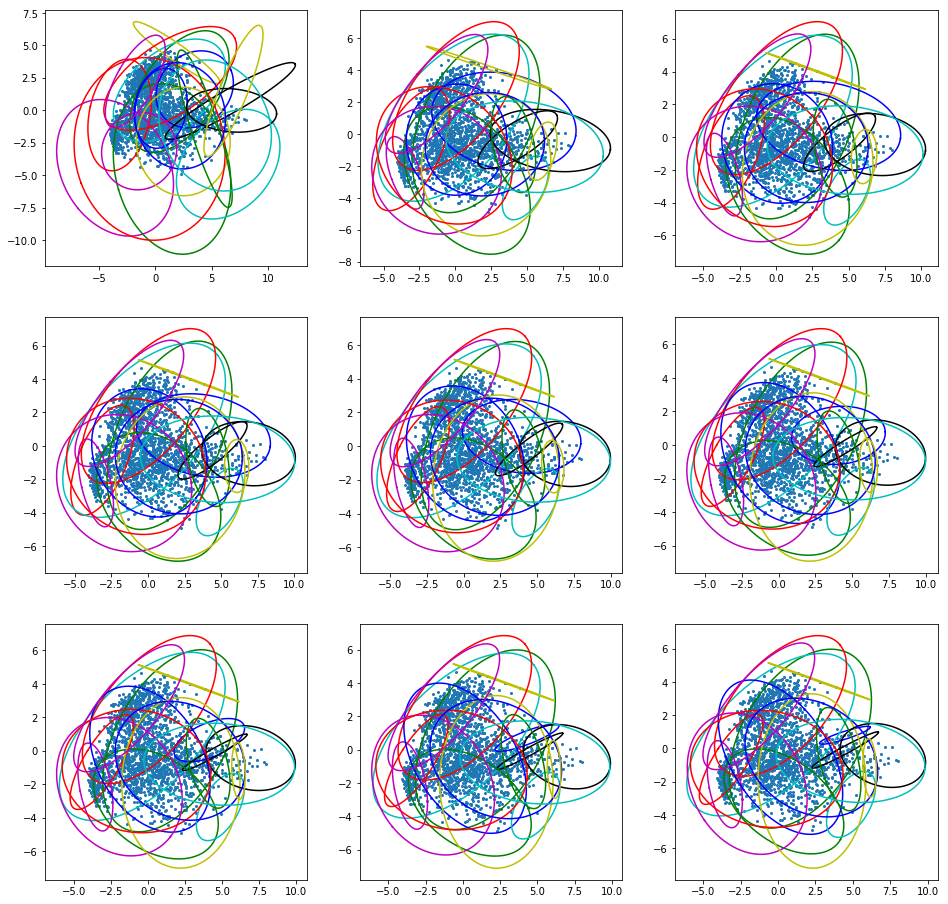

In [552]:
gmmcp = copy.deepcopy(gmm)

if ndim == 2:
    # create figure
    plt.figure(figsize=(16, 16))
# improve model with EM-Algorithm
for i in range(8):
    if ndim == 2:
        # plot current status
        plt.subplot(331 + i)
        gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
if ndim == 2:
    # plot final status
    plt.subplot(339)
    gmmplot(data,gmmcp)

You see, it's not a good cluster in 2 dimension. So, one direction you can explore is **applying GMM in higher dimension space**. However, in that way, it's not easy to illustrate result. You need find a way to do that by yourself.

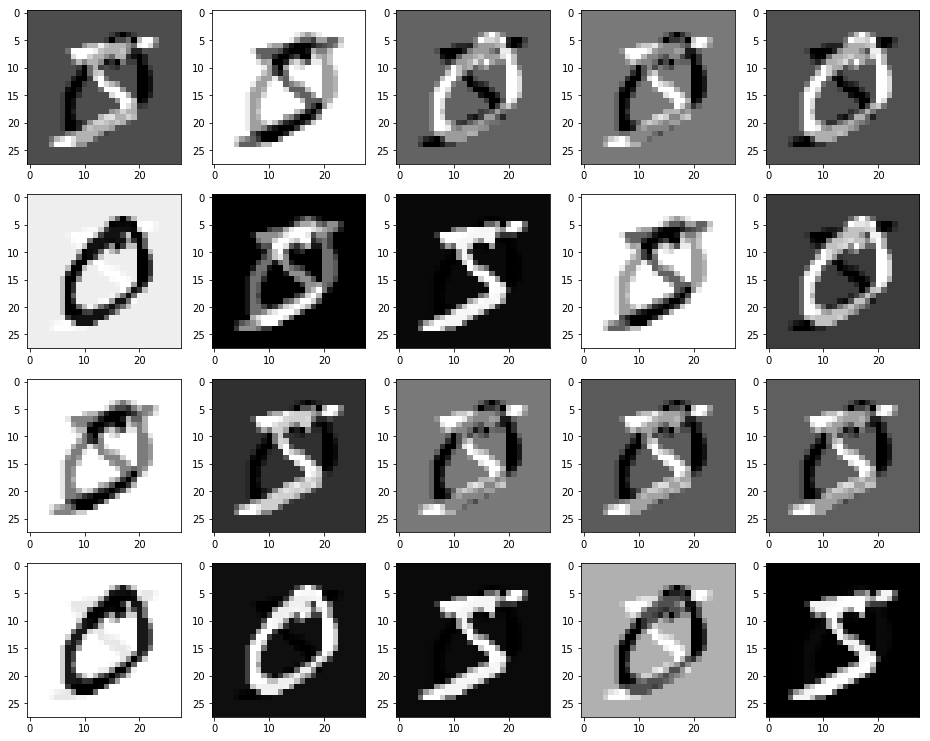

In [514]:
# map cluster center back to image space
clusterCenter = [gmmcp[i]['mean'].dot(eigenVectors[:,0:ndim].T).reshape([28,28]) for i in range(len(gmmcp))]
# illustrate cluster center in image space
showImageSamples(clusterCenter, ngmm, col=5, random=False)

In [515]:
center = []
for i in range(ngmm):
    if gmmcp[i]['prior'] > 0.02:
        print('IND: %d, PRIOR: %f' % (i, gmmcp[i]['prior']))
        center.append(gmmcp[i])
center = np.asarray(center)

IND: 1, PRIOR: 0.100645
IND: 2, PRIOR: 0.035129
IND: 3, PRIOR: 0.272225
IND: 4, PRIOR: 0.158373
IND: 5, PRIOR: 0.022156
IND: 6, PRIOR: 0.046273
IND: 8, PRIOR: 0.170481
IND: 11, PRIOR: 0.022034
IND: 16, PRIOR: 0.072765
IND: 17, PRIOR: 0.044151


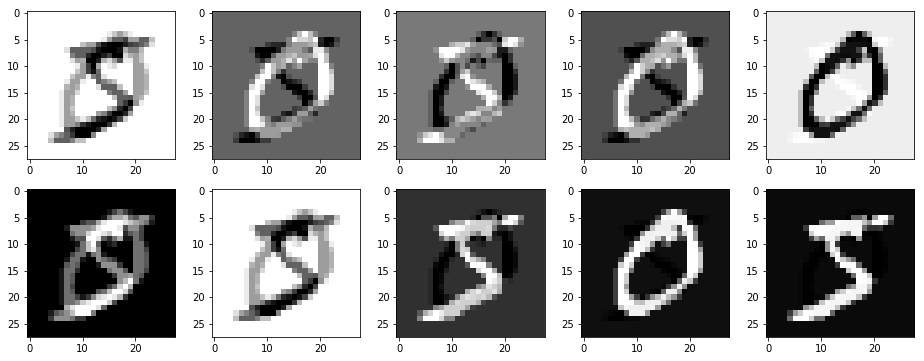

In [516]:
# map cluster center back to image space
clusterCenter = [center[i]['mean'].dot(eigenVectors[:,0:ndim].T).reshape([28,28]) for i in range(len(center))]
# illustrate cluster center in image space
showImageSamples(clusterCenter, len(center), col=5, random=False)